# Contents

- Dataloader
- Implementation
- Train
- Evaluation
- Test
- Prediction
- Reference

In [1]:
import os
import sys
import math
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from scipy.sparse import csr_matrix, dok_matrix
from tqdm import tqdm_notebook as tqdm
from itertools import islice

from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, accuracy_score

In this project, I apply **Bayesian Personalized Ranking** for **implicit** feedback Walmart.com user-item transaction dataset to implement a user response based and personalized ranking recommendation system for future customers.

# Dataloader

Read preprocessed textfiles and convert into sparse matrix format.

In [2]:
# read preprocessed rating textfile
names = ['userId', 'itemId', 'rating']
df = pd.read_csv('../Data/processed_train_2.txt', sep='\t', header=None, names=names)
df_v = pd.read_csv('../Data/processed_validation_2.txt', sep='\t', header=None, names=names)
df_t = pd.read_csv('../Data/processed_test_2.txt', sep='\t', header=None, names=names)

print('Train dimension: {}, Number of users: {}'.format(df.shape, len(set(df.userId))))
print('Validation dimension: {}, Number of users: {}'.format(df_v.shape, len(set(df_v.userId))))
print('Test dimension: {}, Number of users: {}'.format(df_t.shape, len(set(df_t.userId))))

Train dimension: (1180452, 3), Number of users: 34619
Validation dimension: (234524, 3), Number of users: 25048
Test dimension: (125816, 3), Number of users: 18612


In [28]:
%store -r train_user_map
%store -r train_item_map
%store -r cid_map
%store -r catalog_item_id_map

N, M = len(train_user_map), len(train_item_map)
N, M

(34209, 47857)

In [4]:
# convert raw data to sparse user-item matrix
def create_matrix(data, user_col, item_col, rating_col, N, M):
    """
    rtype: scipy sparse matrix csr_matrix, [n_users, n_items]
    """    
    rows = np.array(data[user_col])
    cols = np.array(data[item_col])
    ratings = np.array(data[rating_col])
    
    result = csr_matrix((ratings, (rows, cols)), shape=(N, M))
    result.eliminate_zeros()
    return result, data

In [5]:
X_train, df = create_matrix(df, 'userId', 'itemId', 'rating', N, M)
X_validation, df_v = create_matrix(df_v, 'userId', 'itemId', 'rating', N, M)
X_test, df_t = create_matrix(df_t, 'userId', 'itemId', 'rating', N, M)

# Implementation
Build the recommender by `BPR` based matrix factorization for implicit feedback dataset.

In [6]:
# Bayesian Personalized Ranking
class BPR:
    def __init__(self, n_factors, n_iters, _lambda, lr, batch_size=100, seed=None):
        self.n_factors = n_factors
        self.n_iters = n_iters
        # self.epsilon = epsilon
        self._lambda = _lambda
        self.lr = lr
        self.batch_size = batch_size
        self.seed = seed
    
    
    def fit(self, ratings):
        n_users, n_items = ratings.shape
        indptr, indices = ratings.indptr, ratings.indices
        n_batchs = n_users // self.batch_size
        
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size=(n_users, self.n_factors))
        self.item_factors = rstate.normal(size=(n_items, self.n_factors))
        
        # self.train_loss = []
        # delta_loss = float('inf')
        # _iter = 0
        # while delta_loss >= self.epsilon:
        for n_iter in range(self.n_iters):
        # for n_iter in tqdm(np.arange(self.n_iters), desc='training...'):
            # loss_list = []
            for _ in range(n_batchs):
                users_tmp, pos_items_tmp, neg_items_tmp = self._sample(n_users, n_items, indices, indptr)
                # batch_loss = self._step(users_tmp, pos_items_tmp, neg_items_tmp)
                self._step(users_tmp, pos_items_tmp, neg_items_tmp)
                # loss_list.append(batch_loss)
            
            # loss_iter = np.average(loss_list)
            # self.train_loss.append(loss_iter)
            # print('Iter={}, Loss={}'.format(_iter, loss_iter))
            # _iter += 1
            # if len(self.train_loss) > 1:
                # delta_loss = np.abs(self.train_loss[-2] - self.train_loss[-1])
    
    
    # bootstrap sampling with replacement for optimization
    def _sample(self, n_users, n_items, indices, indptr):
        sampled_users = np.random.choice(n_users, size=self.batch_size, replace=False)
        sampled_pos_items = np.zeros(self.batch_size, dtype=np.int)  ## fix bug: integer index
        sampled_neg_items = np.zeros(self.batch_size, dtype=np.int)
        
        for i, user in enumerate(sampled_users):
            pos_items = indices[indptr[user]:indptr[user + 1]]  
            if len(pos_items) == 0:
                continue

            pos_item = np.random.choice(pos_items)
            neg_item = np.random.choice(n_items)
            while neg_item in pos_items:
                neg_item = np.random.choice(n_items)

            sampled_pos_items[i] = pos_item
            sampled_neg_items[i] = neg_item
        return sampled_users, sampled_pos_items, sampled_neg_items
    
    
    def _step(self, u, i, j):
        user_u = self.user_factors[u]
        item_i, item_j = self.item_factors[i], self.item_factors[j]
        
        # perform a hadamard product instead of dot product to speedup
        r_uij = np.sum(user_u * (item_i-item_j), axis=1)
        
        # triplet loss
        # mse = np.sum(np.log(1 + np.exp(-r_uij)))
        # reg = -sum(u**2 for u in user_u) - sum(i**2 for i in item_i) - sum(j**2 for j in item_j)
        # loss = mse + self._lambda * reg
        
        sigmoid_tmp = np.exp(-r_uij) / (1 + np.exp(-r_uij))  # derivative temp
        sigmoid = np.tile(sigmoid_tmp, (self.n_factors, 1)).T  # match dimension
        
        # update gradient descent
        grad_u = -sigmoid * (item_i-item_j) + self._lambda * user_u
        grad_i = -sigmoid * user_u + self._lambda * item_i
        grad_j = sigmoid * user_u + self._lambda * item_j    
        self.user_factors[u] -= self.lr * grad_u
        self.item_factors[i] -= self.lr * grad_i
        self.item_factors[j] -= self.lr * grad_j
        # return loss
    
    
    def predict(self):
        prediction = self.user_factors.dot(self.item_factors.T)
        return prediction

    
    def _predict_user(self, user):
        u_pred = self.user_factors[user].dot(self.item_factors.T)
        return u_pred
    
    
    def _recommend_user(self, user, N=5):
        u_pred = self._predict_user(user)
        # including the items that user already bought
        indices = np.argpartition(u_pred, -N)[-N:]  # faster than argsort straightly
        ptrs = np.argsort(u_pred[indices])[::-1]
        ranked = indices[ptrs]
        
        result = list(islice((rec for rec in ranked), N))
        # if excluding the items that user liked
        # result = list(slice(rec for rec in ranked if rec not in set(ratings[user].indices)), N)
        return result
    
    
    def recommend(self, users, N=5):
        n_users = len(users)
        recommendation = np.zeros((n_users, N))
        
        for i, user_id in enumerate(users):
            recommendation[i] = self._recommend_user(user_id, N)
        return recommendation
    
    
    def _similar_items(self, item_ids, N=5):
        normed_factors = normalize(self.item_factors)
        # kd-tree for nearest neighbour search by Euclidean metirc
        knn = NearestNeighbors(n_neighbors=N+1, metric='euclidean')
        knn.fit(normed_factors)
        
        selected_items = normed_factors[item_ids]
        _, items = knn.kneighbors(selected_items)
        similar_items = items[:,1:]
        return similar_items

# Train

In [28]:
Params = {
    'n_factors':20,
    # 'n_iters':100,
    'epsilon':1e-3,
    '_lambda':0.01,
    'lr':0.1,
    'batch_size':50,
    'seed':None
}

bpr = BPR(**Params)
bpr.fit(X_train)

Iter=0, Loss=126.34252700985499
Iter=1, Loss=120.05894503535569
Iter=2, Loss=118.12594351655034
Iter=3, Loss=113.87182884994412
Iter=4, Loss=110.94416933447268
Iter=5, Loss=107.58445916916882
Iter=6, Loss=104.94378826603256
Iter=7, Loss=100.96713983488402
Iter=8, Loss=97.76577435818557
Iter=9, Loss=95.78156929954655
Iter=10, Loss=93.18786953584446
Iter=11, Loss=92.64470415231102
Iter=12, Loss=89.36549586434684
Iter=13, Loss=87.94074065595849
Iter=14, Loss=85.62149791138715
Iter=15, Loss=83.97347092766329
Iter=16, Loss=83.22655739904441
Iter=17, Loss=78.65652929372045
Iter=18, Loss=78.12851619778158
Iter=19, Loss=77.7674450536568
Iter=20, Loss=75.28880601760622
Iter=21, Loss=73.53830023925438
Iter=22, Loss=73.45580810517671
Iter=23, Loss=70.48862772566432
Iter=24, Loss=69.63103034261167
Iter=25, Loss=69.37502431116462
Iter=26, Loss=66.9516628641201
Iter=27, Loss=66.15096989329136
Iter=28, Loss=65.58779333317398
Iter=29, Loss=64.24568467285303
Iter=30, Loss=64.29801265141049
Iter=31, Los

Iter=248, Loss=10.967587120065218
Iter=249, Loss=10.49800460779436
Iter=250, Loss=10.710378913490112
Iter=251, Loss=10.818740497500437
Iter=252, Loss=10.84503731566466
Iter=253, Loss=10.764563368715416
Iter=254, Loss=10.918208149684922
Iter=255, Loss=10.627993783682966
Iter=256, Loss=10.6075041296311
Iter=257, Loss=10.773641464079278
Iter=258, Loss=10.551446895926484
Iter=259, Loss=10.642097269829787
Iter=260, Loss=10.608410935168349
Iter=261, Loss=10.69402776411297
Iter=262, Loss=10.367355233383163
Iter=263, Loss=10.411679273185422
Iter=264, Loss=10.50481775388597
Iter=265, Loss=10.759530449872608
Iter=266, Loss=10.57204810312688
Iter=267, Loss=10.378679954807996
Iter=268, Loss=10.278360659698555
Iter=269, Loss=10.403618553025513
Iter=270, Loss=10.533110621121086
Iter=271, Loss=10.475913790756586
Iter=272, Loss=10.449309239059687
Iter=273, Loss=10.392426455795748
Iter=274, Loss=10.599761665369403
Iter=275, Loss=10.26152599153112
Iter=276, Loss=10.14501155704431
Iter=277, Loss=10.25657

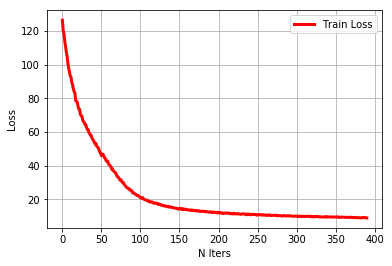

In [29]:
# plot training loss curve
n_iters = 391

plt.plot(np.arange(n_iters), bpr.train_loss, label='Train Loss', linewidth=3, color='r')
plt.xlabel('N Iters')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Therefore, we assume that `150 iters` is enough for model to arrive at convergence.

In [32]:
bpr = BPR(n_factors=20, n_iters=150, _lambda=0.01, lr=0.1, batch_size=50)
bpr.fit(X_train)

# Ranking Metrics

1. Mean Average Precision (**MAP**)
2. Hit Ratio (**HR**)
3. Normalized Discounted Cumulative Gain (**NDCG**)
4. ROC/AUC

In [7]:
## Mean Average Precision
def AP_k(y_label, y_pred, k):
    ground_truth = set(y_label)
    if len(ground_truth) == 0:
        return 0
    
    hit_cnt, precision = 0, 0.0
    for i, p in enumerate(y_pred):
        if p in ground_truth:
            hit_cnt += 1
            precision += hit_cnt / (i + 1.0)

    precision_k = precision / min(len(ground_truth), k)
    return precision_k

def MAP_k(model, ratings, k):
    precision = 0
    n_users = ratings.shape[0]
    
    # for user in tqdm(np.arange(n_users), desc='evaluating...'):
    for user in range(n_users):
        y_label = ratings[user].indices
        u_pred = model._predict_user(user)
        y_pred = np.argsort(u_pred)[::-1][:k]
        precision += AP_k(y_label, y_pred, k)
    
    precision /= n_users
    return precision

In [8]:
## Hit Ratio
def HR_k_helper(y_label, y_pred, k):
    ground_truth = set(y_label)
    if len(ground_truth) == 0:
        return 0, 0
    
    hit_cnt = 0
    for p in y_pred:
        if p in ground_truth:
            hit_cnt += 1
    return hit_cnt, len(ground_truth)

def HR_k(model, ratings, k):
    hits, actuals = 0, 0
    n_users = ratings.shape[0]
    
    for user in range(n_users):
        y_label = ratings[user].indices
        u_pred = model._predict_user(user)
        y_pred = np.argsort(u_pred)[::-1][:k]
        
        tmp1, tmp2 = HR_k_helper(y_label, y_pred, k)
        hits += tmp1
        actuals += tmp2
    return hits / actuals

In [9]:
## Normalized Discounted Cummulative Gain
def DCG_k(y_label, y_pred, k):
    ranked = np.argsort(y_pred)[::-1]
    y_label = np.take(y_label, ranked[:k])

    gains = 2 ** y_label - 1
    discounts = np.log2(np.arange(2, gains.size + 2))

    result = np.sum(gains / discounts)
    return result

def NDCG_k_helper(y_label, y_pred, k):
    actual = DCG_k(y_label, y_pred, k)
    best = DCG_k(y_label, y_label, k)
    
    if not best:
        return 0
    return actual / best

def NDCG_k(model, ratings, k):
    result = 0.0
    n_users, n_items = ratings.shape
    
    for user in range(n_users):
        y_label = np.zeros(n_items)
        indices = ratings[user].indices
        y_label[indices] = 1
        u_pred = model._predict_user(user)
        result += NDCG_k_helper(y_label, u_pred, k)
    
    result /= n_users
    return result

# Evaluation

Use the `validation.txt` for model selection. Based on the experimental experience on `als.ipynb`, we should mainly tune on the parameters like `lr` and `batch_size`.

In [16]:
# fix batch_size=50 and tune on learning rate
lr_list = [0.001, 0.01, 0.1, 1]

ndcg_20_train, ndcg_40_train, ndcg_60_train = [], [], []
ndcg_20_eval, ndcg_40_eval, ndcg_60_eval = [], [], []

for lr in lr_list:
    model = BPR(n_factors=20, n_iters=150, _lambda=0.01, lr=lr, batch_size=50)
    model.fit(X_train)
    
    ndcg_20_train_tmp = NDCG_k(model, X_train, 20)
    ndcg_20_eval_tmp = NDCG_k(model, X_validation, 20)
    ndcg_40_train_tmp = NDCG_k(model, X_train, 40)
    ndcg_40_eval_tmp = NDCG_k(model, X_validation, 40)
    ndcg_60_train_tmp = NDCG_k(model, X_train, 60)
    ndcg_60_eval_tmp = NDCG_k(model, X_validation, 60)
    
    ndcg_20_train.append(ndcg_20_train_tmp)
    ndcg_20_eval.append(ndcg_20_eval_tmp)
    ndcg_40_train.append(ndcg_40_train_tmp)
    ndcg_40_eval.append(ndcg_40_eval_tmp)
    ndcg_60_train.append(ndcg_60_train_tmp)
    ndcg_60_eval.append(ndcg_60_eval_tmp)
    
    print('lr={}'.format(lr))
    print('Train: NDCG_20={}, NDCG_40={}, NDCG_60={}'.format(ndcg_20_train_tmp, ndcg_40_train_tmp, ndcg_60_train_tmp))
    print('Validation: NDCG_20={}, NDCG_40={}, NDCG_60={}'.format(ndcg_20_eval_tmp, ndcg_40_eval_tmp, ndcg_60_eval_tmp))

lr=0.001
Train: NDCG_20=0.0006166207280343966, NDCG_40=0.0007000604827306794, NDCG_60=0.0008839196788543766
Validation: NDCG_20=0.0001868233328348098, NDCG_40=0.0002952269916299446, NDCG_60=0.00039419685172732927
lr=0.01
Train: NDCG_20=0.00035046681686266726, NDCG_40=0.0004093970331193578, NDCG_60=0.0005238643733824095
Validation: NDCG_20=0.00011063339072722821, NDCG_40=0.00016595186831440073, NDCG_60=0.00021589176325967788
lr=0.1
Train: NDCG_20=0.013696386864425095, NDCG_40=0.015187066182716558, NDCG_60=0.018712484834309377
Validation: NDCG_20=0.003666991854582542, NDCG_40=0.00533119130671984, NDCG_60=0.0067241150099941445


/Users/z0g00mx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


lr=1
Train: NDCG_20=0.0006309141355086801, NDCG_40=0.0008562727053459098, NDCG_60=0.001105449443914336
Validation: NDCG_20=0.0001873134028427353, NDCG_40=0.00034265564001149143, NDCG_60=0.0004484922266264652


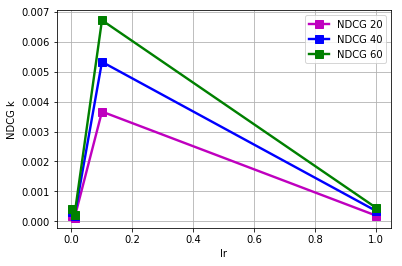

In [19]:
plt.plot(lr_list, ndcg_20_eval, label='NDCG 20', linewidth=2.4, marker='s', MarkerSize=8, color='m')
plt.plot(lr_list, ndcg_40_eval, label='NDCG 40', linewidth=2.4, marker='s', MarkerSize=8, color='b')
plt.plot(lr_list, ndcg_60_eval, label='NDCG 60', linewidth=2.4, marker='s', MarkerSize=8, color='g')
plt.xlabel('lr')
plt.ylabel('NDCG k')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Select `lr=0.1`, then find suitable value of `batch_size`.

In [20]:
batch_list = [20, 40, 60, 80, 100, 120]
ndcg_20_train, ndcg_20_eval = [], []

for batch_size in batch_list:
    model = BPR(n_factors=20, n_iters=150, _lambda=0.01, lr=0.1, batch_size=batch_size)
    model.fit(X_train)
    
    ndcg_20_train_tmp = NDCG_k(model, X_train, 20)
    ndcg_20_eval_tmp = NDCG_k(model, X_validation, 20) 
    ndcg_20_train.append(ndcg_20_train_tmp)
    ndcg_20_eval.append(ndcg_20_eval_tmp)

    
    print('batch_size={}'.format(batch_size))
    print('NDCG_20: train={}, validation={}'.format(ndcg_20_train_tmp, ndcg_20_eval_tmp))

batch_size=20
NDCG_20: train=0.01303866488252439, validation=0.003314000495328688
batch_size=40
NDCG_20: train=0.01344836523688109, validation=0.0034131309335424893
batch_size=60
NDCG_20: train=0.013611387671366063, validation=0.00353848336370237
batch_size=80
NDCG_20: train=0.01527376634600072, validation=0.003876152207448268
batch_size=100
NDCG_20: train=0.014284493778896177, validation=0.0036032811553650262
batch_size=120
NDCG_20: train=0.012898441631856687, validation=0.0035517481254019796


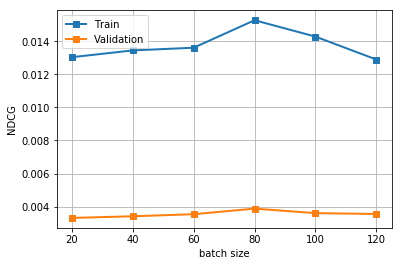

In [21]:
plt.plot(batch_list, ndcg_20_train, label='Train', linewidth=2, marker='s')
plt.plot(batch_list, ndcg_20_eval, label='Validation', linewidth=2, marker='s')
plt.xlabel('batch size')
plt.ylabel('NDCG')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Therefore, the parameters for selected best BPR model in this case should be `BPR(n_factors=20, n_iters=150, _lambda=0.01, lr=0.1, batch_size=80)`.

# Test

Retrain the model using `train.txt` and `validation.txt`.

In [10]:
train_dict = defaultdict(lambda : defaultdict(int))
file_path_1, file_path_2 = '../train.txt', '../validation.txt'

with open(file_path_1, 'r') as f1:
    for line in f1.readlines():
        line = line.split()
        user, item = line[0], line[4]
        if user in train_user_map and item in train_item_map:
            user_id, item_id = train_user_map[user], train_item_map[item]
            train_dict[user_id][item_id] += 1

with open(file_path_2, 'r') as f2:
    for line in f2.readlines():
        line = line.split()
        user, item = line[0], line[4]
        if user in train_user_map and item in train_item_map:
            user_id, item_id = train_user_map[user], train_item_map[item]
            train_dict[user_id][item_id] += 1

# normalize
for uid in train_dict:
    tmp = sum(train_dict[uid].values())
    for iid in train_dict[uid]:
        train_dict[uid][iid] /= tmp

# write re-train file
# with open('../retrain_2.txt', 'w') as h:
#     for uid in sorted(train_dict):
#         for iid in sorted(train_dict[uid]):
#             h.write("{}\t{}\t{}\n".format(uid, iid, train_dict[uid][iid]))
            
# re-train shape same as (N, M)
print('re-train density: {:.4f}%'.format(100 * sum(len(train_dict[u].keys()) for u in train_dict) / (N * M)))

re-train density: 0.0813%


In [10]:
# read re-train
file_rt_path = '../Data/retrain_2.txt'
df_rt = pd.read_csv(file_rt_path, sep='\t', header=None, names=['userId', 'itemId', 'rating'])

X_retrain, df_rt = create_matrix(df_rt, 'userId', 'itemId', 'rating', N, M)
X_retrain

<34619x47880 sparse matrix of type '<class 'numpy.float64'>'
	with 1347335 stored elements in Compressed Sparse Row format>

In [11]:
best_bpr = BPR(n_factors=20, n_iters=150, _lambda=0.01, lr=0.1, batch_size=80)
best_bpr.fit(X_retrain)

Test on `top-K` performance of the mentioned ranking metrics.

In [42]:
k_list = np.arange(10, 90, 10)
ndcg_train, map_train, hr_train = [], [], []
ndcg_test, map_test, hr_test = [], [], []

for k in k_list:
    ndcg_train_tmp = NDCG_k(best_bpr, X_retrain, k)
    map_train_tmp = MAP_k(best_bpr, X_retrain, k)
    hr_train_tmp = HR_k(best_bpr, X_retrain, k)
    ndcg_test_tmp = NDCG_k(best_bpr, X_test, k)
    map_test_tmp = MAP_k(best_bpr, X_test, k)
    hr_test_tmp = HR_k(best_bpr, X_test, k)
    
    ndcg_train.append(ndcg_train_tmp)
    map_train.append(map_train_tmp)
    hr_train.append(hr_train_tmp)
    ndcg_test.append(ndcg_test_tmp)
    map_test.append(map_test_tmp)
    hr_test.append(hr_test_tmp)
    
    print('top-{} performance:'.format(k))
    print('NDCG@{}: retrain={}, test={}'.format(k, ndcg_train_tmp, ndcg_test_tmp))
    print('MAP@{}: retrain={}, test={}'.format(k, map_train_tmp, map_test_tmp))
    print('HR@{}: retrain={}, test={}'.format(k, hr_train_tmp, hr_test_tmp))

top-10 performance:
NDCG@10: retrain=0.015024974784005154, test=0.001555920901441362
MAP@10: retrain=0.004881602576893447, test=0.0006069050736159983
HR@10: retrain=0.003792672201048737, test=0.003203090226998156
top-20 performance:
NDCG@20: retrain=0.015400597991610985, test=0.002288209969655214
MAP@20: retrain=0.003375566922574525, test=0.0006844960100565136
HR@20: retrain=0.007629876756708614, test=0.006954600368792523
top-30 performance:
NDCG@30: retrain=0.01582020879412871, test=0.002982245137198892
MAP@30: retrain=0.002824459780442183, test=0.0007613034190008488
HR@30: retrain=0.011330515424894329, test=0.010586888789979017
top-40 performance:
NDCG@40: retrain=0.016647354131801254, test=0.0035789055196390348
MAP@40: retrain=0.0026088073007890563, test=0.0008171198382596542
HR@40: retrain=0.014956933502061476, test=0.013893304508170662
top-50 performance:
NDCG@50: retrain=0.018007978760458343, test=0.0041099993854400675
MAP@50: retrain=0.0025895185323443425, test=0.000860639186982

Compare with the ALS-based collaborative filtering model in `als.ipynb`.

In [46]:
## output test results from ALS model
ndcg_refer = [0.0258112930751295, 0.027932208255642348, 0.03024926095932075, 0.03209358643890342, 0.033715876784973925, 0.03497359674671582, 0.036185064663018386, 0.03727048692639038]
map_refer = [0.013168246563383697, 0.013007368620834132, 0.013338275152661344, 0.013584138886558088, 0.013781416721680201, 0.013920772506688635, 0.01404182840904329, 0.014138195723767543]
hr_refer = [0.04108380492147263, 0.058076874165447955, 0.07127074457938577, 0.08188147771348636, 0.09179277675335411, 0.10022572645768424, 0.10850766198257773, 0.11594709734850893]

### NDCG@*k*

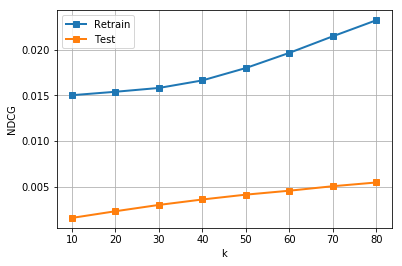

In [48]:
plt.plot(k_list, ndcg_train, label='Retrain', linewidth=2, marker='s')
plt.plot(k_list, ndcg_test, label='Test', linewidth=2, marker='s')
plt.xlabel('k')
plt.ylabel('NDCG')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

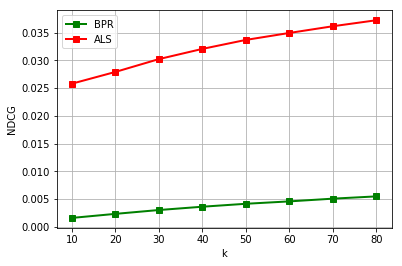

In [53]:
plt.plot(k_list, ndcg_test, label='BPR', linewidth=2, marker='s', color='g')
plt.plot(k_list, ndcg_refer, label='ALS', linewidth=2, marker='s', color='r')
plt.xlabel('k')
plt.ylabel('NDCG')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

### MAP@*k*

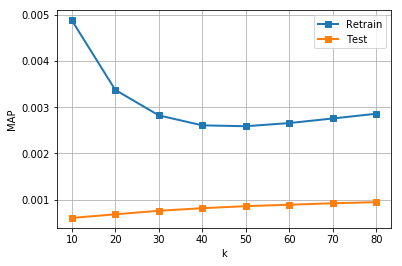

In [50]:
plt.plot(k_list, map_train, label='Retrain', linewidth=2, marker='s')
plt.plot(k_list, map_test, label='Test', linewidth=2, marker='s')
plt.xlabel('k')
plt.ylabel('MAP')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

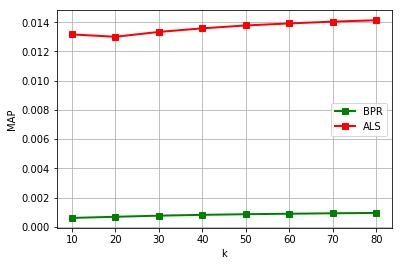

In [54]:
plt.plot(k_list, map_test, label='BPR', linewidth=2, marker='s', color='g')
plt.plot(k_list, map_refer, label='ALS', linewidth=2, marker='s', color='r')
plt.xlabel('k')
plt.ylabel('MAP')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

### HR@*k*

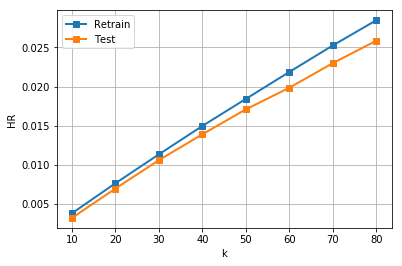

In [55]:
plt.plot(k_list, hr_train, label='Retrain', linewidth=2, marker='s')
plt.plot(k_list, hr_test, label='Test', linewidth=2, marker='s')
plt.xlabel('k')
plt.ylabel('HR')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

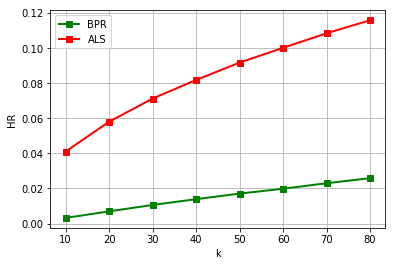

In [56]:
plt.plot(k_list, hr_test, label='BPR', linewidth=2, marker='s', color='g')
plt.plot(k_list, hr_refer, label='ALS', linewidth=2, marker='s', color='r')
plt.xlabel('k')
plt.ylabel('HR')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Based on the plots above, we can infer that ALS based collaborative filtering model is **better** than BPR model in NDCG, MAP and HR performance. The reason may lie in the characteristics of the experiment dataset, which is sparse, imbalanced and does not avail us of good personalized ranking information.

# Prediction

In [22]:
best_bpr.predict()

array([[ 1.15761653,  0.37016461,  1.47883627, ..., -1.83025324,
         1.37771964,  0.16977549],
       [ 1.34077303,  0.51186517, -0.98067459, ...,  1.40964061,
        -2.66021338,  0.69753098],
       [ 1.7096995 , -0.30278847,  0.61325356, ..., -0.82418457,
         0.42611804,  3.56812947],
       ...,
       [ 2.14352024,  0.93259054,  1.58201338, ...,  0.19664345,
        -0.68878306,  3.73181802],
       [ 0.83476813, -1.02479363,  1.79079984, ...,  0.03061398,
         0.97822007,  1.72079108],
       [ 0.19280849, -4.50855507,  0.63547388, ...,  2.12906732,
         3.35159741,  2.84510486]])

In [29]:
# sample 5 customers for recommendation
## for convenience of comparison, choose same sampled users as als.ipynb
n_samples = 5
sampled_users = np.random.choice(list(train_user_map.keys()), n_samples)
sampled_users

array(['f01625907c820e67e044001517f43a86',
       'f225b959800b5bc8e044001517f43a86',
       '561ff9d2212e4e2d810911007bc5ea51',
       '689ca614adb348068a16aea65eeadbdf',
       'f045b60528f40df3e044001517f43a86'], dtype='<U32')

In [30]:
sampled_user_ids = list(map(lambda x:train_user_map.get(x), sampled_users))
sampled_user_ids

[27273, 9763, 22587, 4819, 13950]

In [31]:
u_pred = list(map(lambda x:best_bpr._predict_user(x), sampled_user_ids))
u_pred

[array([ 4.21309436, -2.55959533,  3.25331874, ..., -2.38317906,
         0.84064299,  0.98661759]),
 array([ 0.7212844 , -1.35075743,  1.44362175, ..., -0.92343721,
         0.89865232,  0.76887619]),
 array([ 2.69197317,  3.79533584,  1.24286497, ..., -1.79773316,
        -1.8375847 ,  2.43207894]),
 array([-0.02910414, -1.03191541,  1.37563844, ...,  1.61613762,
         1.5220198 , -0.4797889 ]),
 array([ 2.60325984, -0.90133929,  2.41927806, ..., -2.65409957,
        -2.20440002,  1.06161433])]

In [32]:
y_pred = list(map(lambda x:np.argsort(x)[::-1][:4], u_pred))  # k=4
y_pred

[array([ 5443,  1969,  2780, 29550]),
 array([20174, 14283, 31218,  4423]),
 array([18605,  8051, 30924, 10100]),
 array([14191, 40721, 24400, 30977]),
 array([2592, 4692, 2746, 4326])]

In [33]:
y_pred_output = list(list(map(lambda x:catalog_item_id_map.get(x), user_vec)) for user_vec in y_pred)
y_pred_output

[['38444752', '53989313', '10308562', '34809347'],
 ['894532133', '46857865', '50018607', '14922696'],
 ['24547740', '10293844', '34223498', '10324598'],
 ['197347253', '515153592', '404894664', '198013918'],
 ['43830574', '45090383', '122270233', '796108312']]

In [34]:
# recommend 6 items for each sampled user
best_bpr.recommend(sampled_user_ids, N=6)

array([[ 5443.,  1969.,  2780., 29550.,   137.,  7200.],
       [20174., 14283., 31218.,  4423., 27087., 29881.],
       [18605.,  8051., 30924., 10100., 27693., 13886.],
       [14191., 40721., 24400., 30977., 30540., 32654.],
       [ 2592.,  4692.,  2746.,  4326.,  3021.,  3246.]])

In [35]:
# sample 5 items
sampled_items = np.random.choice(list(train_item_map.keys()), n_samples)
sampled_items

array(['746072402', '13908655', '348644211', '48745760', '10318343'],
      dtype='<U10')

In [36]:
sampled_item_ids = list(map(lambda x:train_item_map.get(x), sampled_items))
sampled_item_ids

[27808, 21251, 2605, 40106, 2187]

In [37]:
# find most similar 5 items for each sample
simi_items = best_bpr._similar_items(sampled_item_ids, N=5)
simi_items

array([[13137, 11404, 11212,  5107, 31383],
       [ 9455, 16392, 24049, 34587, 28563],
       [ 5517,  6979, 15464,  9842,  2970],
       [39470, 40185, 19319, 46323, 16383],
       [18526,  5126,  6588,  6897,  8041]])

# Reference

[BPR: Bayesian Personalized Ranking from Implicit Feedback](https://arxiv.org/pdf/1205.2618.pdf)